In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

# core knobs
TAKE_UP_RATE = 0.65               # baseline childcare take-up
CAPACITY_PER_CENTRE = 100         # given by scenario norm
FORECAST_HORIZON_YEARS = 5        # next 5 years
HOLDOUT_YEARS = 5                 # simple backtest window (2016–2020)

# BTO uplift knobs 
CHILDREN_PER_UNIT = 0.25          # expected #children (18m–6y) per new flat over near-term
BTO_DEMAND_TAKEUP = TAKE_UP_RATE  # assume same take-up for BTO kids

In [3]:
def load_respop(path):
    sheets = ["2000", "2001-2010", "2011-2019", "2020"]
    dfs = []
    for sh in sheets:
        df = pd.read_excel(path, sheet_name=sh, header=2)
        year_cols = [c for c in df.columns if isinstance(c, (int, np.integer))]
        df = df.rename(columns={"Planning Area":"planning_area", "Subzone":"subzone", "Age":"age", "Sex":"sex"})
        df_long = df.melt(
            id_vars=["planning_area","subzone","age","sex"],
            value_vars=year_cols,
            var_name="year",
            value_name="pop"
        )
        dfs.append(df_long)

    out = pd.concat(dfs, ignore_index=True)
    out["subzone"] = out["subzone"].astype(str).str.strip()
    out["planning_area"] = out["planning_area"].astype(str).str.strip()
    out["sex"] = out["sex"].astype(str).str.strip()
    return out

respop_long = load_respop("../data/respopagesex2000to2020e.xlsx")
respop_long.head()

,planning_area,subzone,age,sex,year,pop
0,Total,Total,Total,Total,2000,3273360
1,Total,Total,Total,Males,2000,1634670
2,Total,Total,Total,Females,2000,1638700
3,Total,Total,0,Total,2000,40810
4,Total,Total,0,Males,2000,21170


In [4]:
# remove non-geographic placeholder subzones
respop_long = respop_long[
    ~respop_long["subzone"].str.match(r"^Subzone\s+\d+$", na=False)
].copy()

# clean - in pop
respop_long["pop"] = pd.to_numeric(respop_long["pop"], errors="coerce").fillna(0).astype(int)

# keep only Total sex for demand sizing
respop_total = respop_long[respop_long["sex"].eq("Total")].copy()

# age column contains ints and Total, keep numeric ages
respop_total["age_num"] = pd.to_numeric(respop_total["age"], errors="coerce")
respop_total = respop_total.dropna(subset=["age_num"])
respop_total["age_num"] = respop_total["age_num"].astype(int)

# proxy for 18m to 6yo
# use ages >= 2 + half of 1 (assume half of 1yo are 18–23m)
AGE_MAIN = [2,3,4,5,6]
AGE_HALF = [1]

res_2to6 = respop_total[respop_total["age_num"].isin(AGE_MAIN)].groupby(
    ["planning_area","subzone","year"], as_index=False
)["pop"].sum().rename(columns={"pop":"pop_age2to6"})

res_age1 = respop_total[respop_total["age_num"].isin(AGE_HALF)].groupby(
    ["planning_area","subzone","year"], as_index=False
)["pop"].sum().rename(columns={"pop":"pop_age1"})

child_proxy = res_2to6.merge(res_age1, on=["planning_area","subzone","year"], how="left")
child_proxy["pop_age1"] = child_proxy["pop_age1"].fillna(0)
child_proxy["pop_18m_to_6y"] = child_proxy["pop_age2to6"] + 0.5 * child_proxy["pop_age1"]

# baseline "demand" proxy = cohort + take-up
child_proxy["demand_children"] = child_proxy["pop_18m_to_6y"] * TAKE_UP_RATE

child_proxy.head()

,planning_area,subzone,year,pop_age2to6,pop_age1,pop_18m_to_6y,demand_children
0,Ang Mo Kio,Ang Mo Kio Town Centre,2011,300,40,320.0,208.00
1,Ang Mo Kio,Ang Mo Kio Town Centre,2012,260,50,285.0,185.25
2,Ang Mo Kio,Ang Mo Kio Town Centre,2013,260,60,290.0,188.50
3,Ang Mo Kio,Ang Mo Kio Town Centre,2014,280,50,305.0,198.25
4,Ang Mo Kio,Ang Mo Kio Town Centre,2015,290,50,315.0,204.75


In [5]:
births = pd.read_csv("../data/BirthsAndFertilityRatesAnnual.csv")
births.head()

,DataSeries,2024,2023,2022,2021,2020,2019,2018,2017,2016,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,Total Fertility Rate (TFR),0.97,0.97,1.04,1.12,1.1,1.14,1.14,1.16,1.2,...,3.22,3.53,3.91,4.46,4.66,4.97,5.16,5.21,5.41,5.76
1,15 - 19 Years,2.30,2.20,2.10,2.20,2.3,2.50,2.50,2.60,2.7,...,27.1,30.9,35.8,33,35.9,38.3,45.7,52,63.4,69.6
2,20 - 24 Years,9.80,10.60,11.20,11.70,12.7,12.70,14.40,15.10,17.0,...,150.1,165.8,195.8,218.5,227.1,240,249,245.5,241.1,250.5
3,25 - 29 Years,42.60,43.70,48.80,53.40,54.6,59.40,60.60,62.20,65.8,...,227.8,236.6,244.7,261.2,259.5,277.6,287.2,291.7,304.9,323.9
4,30 - 34 Years,79.30,78.70,86.70,92.90,90.8,92.40,92.90,93.30,96.2,...,134.3,152,166.7,202,216.2,226.7,228.7,231.5,238.4,259.7


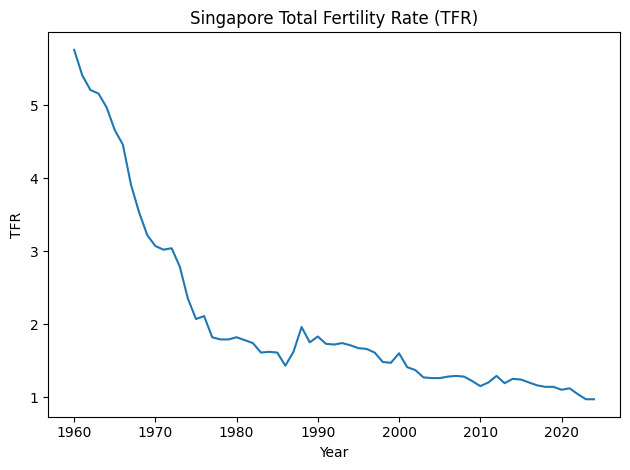

In [6]:
tfr = births[births["DataSeries"].str.contains("Total Fertility Rate", na=False)].copy()

# transpose dataset
year_cols = [c for c in tfr.columns if c != "DataSeries"]
tfr_long = tfr.melt(id_vars=["DataSeries"], value_vars=year_cols, var_name="year", value_name="tfr")
tfr_long["year"] = pd.to_numeric(tfr_long["year"], errors="coerce")
tfr_long["tfr"]  = pd.to_numeric(tfr_long["tfr"],  errors="coerce")
tfr_long = tfr_long.dropna(subset=["year"]).sort_values("year")

plt.figure()
plt.plot(tfr_long["year"], tfr_long["tfr"])
plt.title("Singapore Total Fertility Rate (TFR)")
plt.xlabel("Year")
plt.ylabel("TFR")
plt.tight_layout()
plt.savefig("sg_tfr.png")
plt.show()

In [7]:
# forecast demand per subzone (ETS/exponential smoothing)
# ETS because fast, explainable, reasonable for many small-area time series

# fit ETS time series model and produce forward forecast
def fit_forecast_ets(y, horizon):
    y = y.astype(float)
    
    # if nearly constant, extend last value (prevent optimiser issues)
    if np.nanstd(y.values) < 1e-6:
        last = float(y.iloc[-1])
        idx = pd.date_range(y.index[-1] + pd.offsets.YearBegin(1), periods=horizon, freq="YS")
        return pd.Series([last]*horizon, index=idx)
    
    # try optimized fit
    try:
        # additive trend, no seasonality (annual series)
        m = ExponentialSmoothing(y, trend="add", seasonal=None, damped_trend=True)
        res = m.fit(optimized=True)
        return res.forecast(horizon)
    # if fail, fallback to fixed smoothing
    except Exception:
        m = ExponentialSmoothing(y, trend="add", seasonal=None, damped_trend=True)
        res = m.fit(
            smoothing_level=0.4,
            smoothing_trend=0.2,
            optimized=False
        )
        return res.forecast(horizon)
    
def to_yearly_datetime_index(df, year_col="year", value_col="demand_children"):
    s = pd.Series(df[value_col].values, index=pd.to_datetime(df[year_col].astype(int), format="%Y"))
    s = s.asfreq("YS") 
    return s

# build subzone + year annual series of demand
demand_ts = child_proxy.groupby(["subzone","year"], as_index=False)["demand_children"].sum()

# forecast next 5 years from latest available year
last_year = int(demand_ts["year"].max())
fc_years = list(range(last_year + 1, last_year + 1 + FORECAST_HORIZON_YEARS))

# forecast each subzone
fc_rows = []
for sz, g in demand_ts.groupby("subzone"):
    g = g.sort_values("year")
    y = to_yearly_datetime_index(g, year_col="year", value_col="demand_children")
    if len(y) < 8:
        continue  # too short to be meaningful; keep it simple
    fc = fit_forecast_ets(y, horizon=FORECAST_HORIZON_YEARS)
    for yr, val in zip(fc_years, fc.values):
        fc_rows.append({"subzone": sz, "year": int(yr), "demand_children_fc": max(0.0, float(val))})

demand_fc = pd.DataFrame(fc_rows)

# combine history and forecast
demand_hist = demand_ts.rename(columns={"demand_children":"demand_children_hist"})
demand_all = demand_hist.merge(demand_fc, on=["subzone","year"], how="outer").sort_values(["subzone","year"])
demand_all.head()

/Users/bytedance/miniconda3/envs/govtech/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,subzone,year,demand_children_hist,demand_children_fc
0,Admiralty,2000,136.50,NaN
1,Admiralty,2001,256.75,NaN
2,Admiralty,2002,341.25,NaN
3,Admiralty,2003,396.50,NaN
4,Admiralty,2004,497.25,NaN


In [8]:
# backtest metrics (holdout = last 5 years in data)
def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.maximum(1.0, np.abs(y_true))
    return np.mean(np.abs(y_true - y_pred) / denom)

metrics = []
for sz, g in demand_ts.groupby("subzone"):
    g = g.sort_values("year")
    # skip subzones with little history
    if len(g) < (HOLDOUT_YEARS + 8):
        continue

    train = g.iloc[:-HOLDOUT_YEARS]
    test = g.iloc[-HOLDOUT_YEARS:]

    y_train = pd.Series(
        train["demand_children"].values,
        index=pd.to_datetime(train["year"].astype(int), format="%Y")
    ).asfreq("YS")
    y_test = pd.Series(
        test["demand_children"].values,
        index=pd.to_datetime(test["year"].astype(int), format="%Y")
    ).asfreq("YS")
    fc = fit_forecast_ets(y_train, horizon=HOLDOUT_YEARS)
    fc = fc.clip(lower=0)

    m = mape(test["demand_children"].values, fc.values)
    metrics.append({"subzone": sz, "mape": m, "avg_demand_test": test["demand_children"].mean(), "avg_demand_fc": fc.mean()})

metrics_df = pd.DataFrame(metrics).sort_values("mape")
metrics_df.head(10)

,subzone,mape,avg_demand_test,avg_demand_fc
163,People's Park,0.0,0.0,0.0
230,Tengeh,0.0,0.0,0.0
231,The Wharves,0.0,0.0,0.0
113,Lim Chu Kang,0.0,0.0,0.0
58,Defu Industrial Park,0.0,0.0,0.0
200,Shipyard,0.0,0.0,0.0
115,Liu Fang,0.0,0.0,0.0
53,Clifford Pier,0.0,0.0,0.0
63,East Coast,0.0,0.0,0.0
194,Senoko West,0.0,0.0,0.0


In [9]:
bto = pd.read_csv("../data/btomapping.csv")
bto.head()

,BTO project name,Region,Planning area,Subzone,Estimated completion year,Total number of units
0,Toa Payoh Apex,Central Region,Toa Payoh,Boon Teck,2018,557
1,Fengshan GreenVille,East Region,Bedok,Bedok North,2018,1058
2,Sun Breeze,North Region,Sembawang,Sembawang Central,2018,700
3,Sun Natura,North Region,Sembawang,Sembawang Central,2018,848
4,Marsiling Greenview,North Region,Woodlands,Woodlands West,2018,1304


In [10]:
bto = bto.rename(columns={
    "Subzone":"subzone",
    "Estimated completion year":"completion_year",
    "Total number of units":"units"
})
bto["subzone"] = bto["subzone"].astype(str).str.strip()
bto["completion_year"] = pd.to_numeric(bto["completion_year"], errors="coerce")
bto["units"] = pd.to_numeric(bto["units"], errors="coerce")

# keep only years that impact forecast window (future + within forecast horizon)
bto_window = bto[
    (bto["completion_year"] >= last_year + 1) &
    (bto["completion_year"] <= last_year + FORECAST_HORIZON_YEARS)
].copy()

# convert to incremental demand children (per year, subzone)
bto_window["bto_kids_18m_6y"] = bto_window["units"] * CHILDREN_PER_UNIT
bto_window["bto_demand_uplift"] = bto_window["bto_kids_18m_6y"] * BTO_DEMAND_TAKEUP

bto_uplift = bto_window.groupby(["subzone","completion_year"], as_index=False)["bto_demand_uplift"].sum()
bto_uplift = bto_uplift.rename(columns={"completion_year":"year"})

bto_uplift.head()

,subzone,year,bto_demand_uplift
0,Aljunied,2021,155.0250
1,Aljunied,2025,68.4125
2,Anchorvale,2022,33.6375
3,Bedok North,2021,81.2500
4,Bedok South,2021,152.7500


In [11]:
# merge BTO uplift into forecast years
demand_fc_u = demand_fc.merge(bto_uplift, on=["subzone","year"], how="left")

# missing uplift = no BTO impact
demand_fc_u["bto_demand_uplift"] = demand_fc_u["bto_demand_uplift"].fillna(0.0)

# adjusted forecast = baseline forecast + BTO uplift
demand_fc_u["demand_children_fc_adj"] = (
    demand_fc_u["demand_children_fc"] + demand_fc_u["bto_demand_uplift"]
)

demand_fc_u.head()

,subzone,year,demand_children_fc,bto_demand_uplift,demand_children_fc_adj
0,Admiralty,2021,552.856375,0.0,552.856375
1,Admiralty,2022,534.338486,0.0,534.338486
2,Admiralty,2023,519.025546,0.0,519.025546
3,Admiralty,2024,506.362866,0.0,506.362866
4,Admiralty,2025,495.891757,0.0,495.891757


In [12]:
plan_year = last_year + FORECAST_HORIZON_YEARS

# baseline (latest year) for comparison
baseline = demand_ts[demand_ts["year"] == last_year].copy()
baseline["baseline_method"] = "observed"

# --- NEW: back-fill baseline for subzones missing in 2020 using last historical value ---
all_subzones = demand_ts["subzone"].unique()
observed_subzones = baseline["subzone"].unique()
missing_subzones = np.setdiff1d(all_subzones, observed_subzones)

# last observed (pre-2020) demand per missing subzone
hist_last = (
    demand_ts[demand_ts["year"] < last_year]
    .sort_values(["subzone", "year"])
    .groupby("subzone", as_index=False)
    .tail(1)
)

hist_last = hist_last[hist_last["subzone"].isin(missing_subzones)].copy()
hist_last["year"] = last_year
hist_last["baseline_method"] = "backfilled_last_observed"

# append backfilled rows into baseline
baseline = pd.concat([baseline, hist_last], ignore_index=True)

# take ceiling since centres have to be full unit
baseline["required_centres_hist"] = np.ceil(
    baseline["demand_children"] / CAPACITY_PER_CENTRE
).astype(int)

# plan-year forecast
plan = demand_fc_u[demand_fc_u["year"] == plan_year].copy()
plan = plan.rename(columns={"demand_children_fc_adj": "demand_children_plan"})

# take ceiling since centres have to be full unit
plan["required_centres_plan"] = np.ceil(
    plan["demand_children_plan"] / CAPACITY_PER_CENTRE
).astype(int)

# compare future vs today
plan = plan.merge(
    baseline[["subzone","required_centres_hist","demand_children","baseline_method"]],
    on="subzone",
    how="left"
)

# growth in centres needed over 5 years
plan["delta_centres_5y"] = (
    plan["required_centres_plan"]
    - plan["required_centres_hist"].fillna(0).astype(int)
)

# rank subzones by urgency
plan = plan.sort_values(
    ["delta_centres_5y","required_centres_plan"],
    ascending=False
)

plan.head()

,subzone,year,demand_children_fc,bto_demand_uplift,demand_children_plan,required_centres_plan,required_centres_hist,demand_children,baseline_method,delta_centres_5y
290,Tampines North,2025,3086.688169,0.0,3086.688169,31,7,669.5,observed,24
29,Brickworks,2025,3747.549433,0.0,3747.549433,38,15,1482.0,observed,23
248,Sembawang East,2025,3091.000102,0.0,3091.000102,31,12,1118.0,observed,19
328,Waterway East,2025,5253.698379,0.0,5253.698379,53,41,4082.0,observed,12
229,Punggol Town Centre,2025,2889.702117,0.0,2889.702117,29,20,1969.5,observed,9


In [13]:
TOPN = 20

priority_table = plan[[
    "subzone",
    "baseline_method",
    "demand_children",          # latest observed demand
    "required_centres_hist",    # centres implied today
    "demand_children_plan",     # forecast demand (plan year)
    "required_centres_plan",    # centres implied in plan year
    "delta_centres_5y"          # additional centres needed
]].head(TOPN)

priority_table

,subzone,baseline_method,demand_children,required_centres_hist,demand_children_plan,required_centres_plan,delta_centres_5y
290,Tampines North,observed,669.50,7,3086.688169,31,24
29,Brickworks,observed,1482.00,15,3747.549433,38,23
248,Sembawang East,observed,1118.00,12,3091.000102,31,19
328,Waterway East,observed,4082.00,41,5253.698379,53,12
229,Punggol Town Centre,observed,1969.50,20,2889.702117,29,9
202,Pasir Ris Central,observed,1251.25,13,1829.984772,19,6
6,Anchorvale,observed,2882.75,29,3318.558712,34,5
110,Jalan Kayu East,backfilled_last_observed,955.50,10,1403.057023,15,5
251,Sembawang Springs,observed,367.25,4,848.677441,9,5
291,Tampines West,observed,2739.75,28,3187.080864,32,4


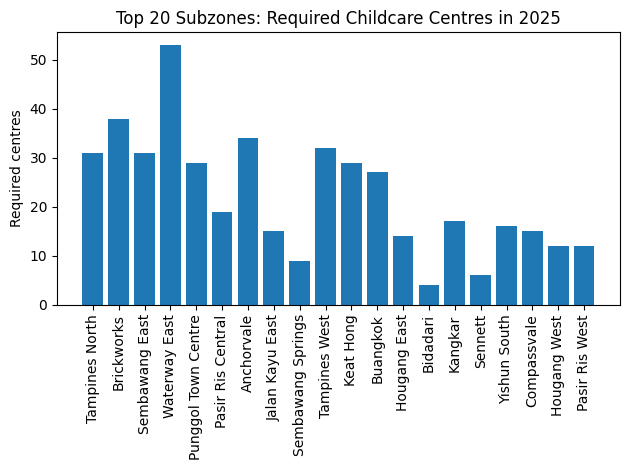

In [14]:
plt.figure()
plt.bar(np.arange(TOPN), priority_table["required_centres_plan"].values)
plt.xticks(np.arange(TOPN), priority_table["subzone"].values, rotation=90)
plt.title(f"Top {TOPN} Subzones: Required Childcare Centres in {plan_year}")
plt.ylabel("Required centres")
plt.tight_layout()
plt.savefig("top20_required_centres_2025.png")
plt.show()

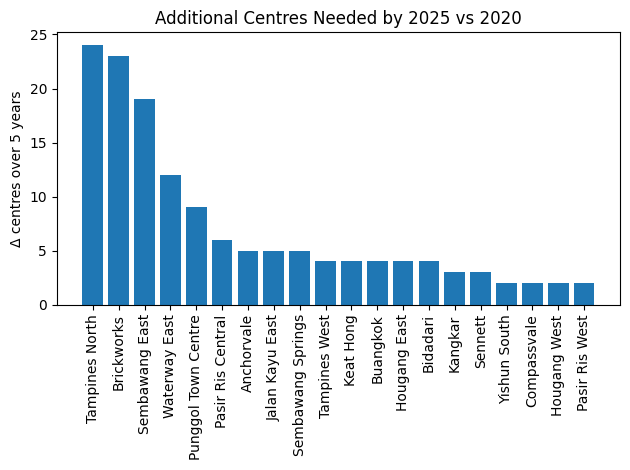

In [15]:
plt.figure()
plt.bar(
    np.arange(TOPN),
    priority_table["delta_centres_5y"].values
)
plt.xticks(
    np.arange(TOPN),
    priority_table["subzone"].values,
    rotation=90
)
plt.title(
    f"Additional Centres Needed by {plan_year} vs {last_year}"
)
plt.ylabel("Δ centres over 5 years")
plt.tight_layout()
plt.savefig("additional_centres_2025_2020.png")
plt.show()

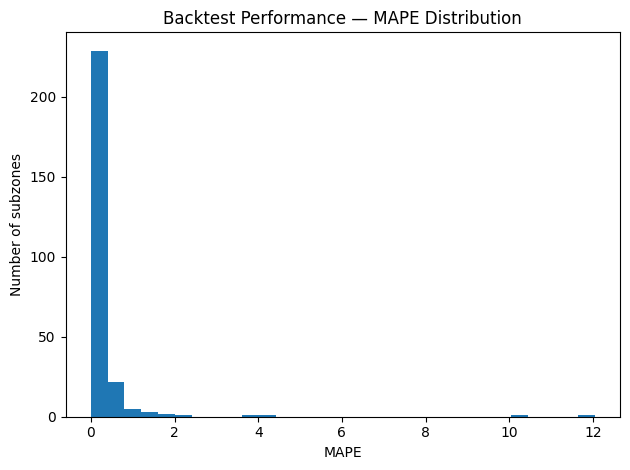

count    266.000000
mean       0.301318
std        1.050900
min        0.000000
25%        0.000000
50%        0.087822
75%        0.246224
max       12.046105
Name: mape, dtype: float64

In [16]:
plt.figure()
plt.hist(metrics_df["mape"].values, bins=30)
plt.title("Backtest Performance — MAPE Distribution")
plt.xlabel("MAPE")
plt.ylabel("Number of subzones")
plt.tight_layout()
plt.savefig("backtest_mape.png")
plt.show()

metrics_df["mape"].describe()


In [17]:
def run_planning_update(
    child_proxy_df,
    bto_df=None,
    take_up_rate=TAKE_UP_RATE,
    cap_per_centre=CAPACITY_PER_CENTRE,
    horizon_years=FORECAST_HORIZON_YEARS
):
    # aggregate demand history
    demand_ts = child_proxy_df.groupby(["subzone","year"], as_index=False)["demand_children"].sum()
    last_year = int(demand_ts["year"].max())
    fc_years = list(range(last_year + 1, last_year + 1 + horizon_years))

    # forecast each subzone
    fc_rows = []
    for sz, g in demand_ts.groupby("subzone"):
        g = g.sort_values("year")
        y = to_yearly_datetime_index(g, year_col="year", value_col="demand_children")
        if len(y) < 8:
            continue
        fc = fit_forecast_ets(y, horizon=horizon_years)
        for yr, val in zip(fc_years, fc.values):
            fc_rows.append({"subzone": sz, "year": int(yr), "demand_children_fc": max(0.0, float(val))})

    demand_fc = pd.DataFrame(fc_rows)

    # BTO uplift, allow if empty
    if (bto_df is None) or (len(bto_df) == 0):
        bto_uplift = pd.DataFrame(columns=["subzone","year","bto_demand_uplift"])
    else:
        bto = bto_df.copy()

        bto = bto.rename(columns={
            "Subzone":"subzone",
            "Estimated completion year":"completion_year",
            "Total number of units":"units"
        })
        bto["subzone"] = bto["subzone"].astype(str).str.strip()
        bto["completion_year"] = pd.to_numeric(bto["completion_year"], errors="coerce")
        bto["units"] = pd.to_numeric(bto["units"], errors="coerce")

        bto_window = bto[
            (bto["completion_year"] >= last_year + 1) &
            (bto["completion_year"] <= last_year + horizon_years)
        ].copy()

        bto_window["bto_kids_18m_6y"] = bto_window["units"] * CHILDREN_PER_UNIT
        bto_window["bto_demand_uplift"] = bto_window["bto_kids_18m_6y"] * take_up_rate

        bto_uplift = (
            bto_window.groupby(["subzone","completion_year"], as_index=False)["bto_demand_uplift"].sum()
            .rename(columns={"completion_year":"year"})
        )

    # merge uplift into forecast years
    demand_fc_u = demand_fc.merge(bto_uplift, on=["subzone","year"], how="left")
    demand_fc_u["bto_demand_uplift"] = demand_fc_u["bto_demand_uplift"].fillna(0.0)
    demand_fc_u["demand_children_fc_adj"] = demand_fc_u["demand_children_fc"] + demand_fc_u["bto_demand_uplift"]

    # plan year
    plan_year = last_year + horizon_years

    # baseline (latest year) for comparison
    baseline = demand_ts[demand_ts["year"] == last_year].copy()
    baseline["baseline_method"] = "observed"

    # back-fill baseline for subzones missing in last_year using last historical value
    all_subzones = demand_ts["subzone"].unique()
    observed_subzones = baseline["subzone"].unique()
    missing_subzones = np.setdiff1d(all_subzones, observed_subzones)

    hist_last = (
        demand_ts[demand_ts["year"] < last_year]
        .sort_values(["subzone","year"])
        .groupby("subzone", as_index=False)
        .tail(1)
    )
    hist_last = hist_last[hist_last["subzone"].isin(missing_subzones)].copy()
    hist_last["year"] = last_year
    hist_last["baseline_method"] = "backfilled_last_observed"

    baseline = pd.concat([baseline, hist_last], ignore_index=True)

    # centres implied today
    baseline["required_centres_hist"] = np.ceil(baseline["demand_children"] / cap_per_centre).astype(int)

    # plan-year forecast
    plan = demand_fc_u[demand_fc_u["year"] == plan_year].copy()
    plan = plan.rename(columns={"demand_children_fc_adj": "demand_children_plan"})

    # centres implied in plan year
    plan["required_centres_plan"] = np.ceil(plan["demand_children_plan"] / cap_per_centre).astype(int)

    # compare future vs today
    plan = plan.merge(
        baseline[["subzone","required_centres_hist","demand_children","baseline_method"]],
        on="subzone",
        how="left"
    )

    # growth in centres needed over horizon
    plan["delta_centres_{}y".format(horizon_years)] = (
        plan["required_centres_plan"] - plan["required_centres_hist"].fillna(0).astype(int)
    )

    # rank by urgency
    plan = plan.sort_values(
        ["delta_centres_{}y".format(horizon_years), "required_centres_plan"],
        ascending=False
    )

    return plan

plan_update = run_planning_update(child_proxy, bto)
plan_update.head(10)

/Users/bytedance/miniconda3/envs/govtech/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,subzone,year,demand_children_fc,bto_demand_uplift,demand_children_plan,required_centres_plan,required_centres_hist,demand_children,baseline_method,delta_centres_5y
290,Tampines North,2025,3086.688169,0.000,3086.688169,31,7,669.50,observed,24
29,Brickworks,2025,3747.549433,0.000,3747.549433,38,15,1482.00,observed,23
248,Sembawang East,2025,3091.000102,0.000,3091.000102,31,12,1118.00,observed,19
328,Waterway East,2025,5253.698379,0.000,5253.698379,53,41,4082.00,observed,12
229,Punggol Town Centre,2025,2889.702117,0.000,2889.702117,29,20,1969.50,observed,9
202,Pasir Ris Central,2025,1656.109772,173.875,1829.984772,19,13,1251.25,observed,6
6,Anchorvale,2025,3318.558712,0.000,3318.558712,34,29,2882.75,observed,5
110,Jalan Kayu East,2025,1403.057023,0.000,1403.057023,15,10,955.50,backfilled_last_observed,5
251,Sembawang Springs,2025,730.702441,117.975,848.677441,9,4,367.25,observed,5
291,Tampines West,2025,2802.605864,384.475,3187.080864,32,28,2739.75,observed,4
